# Import the libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, expon
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import plotly.express as px
import pandas as pd

# Market risk models

In [20]:
def simulate_market_risk(S0, mu, sigma, T, n_simulations, n_steps):
    dt = T / n_steps
    simulations = np.zeros((n_steps + 1, n_simulations))
    simulations[0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_simulations)
        simulations[t] = simulations[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    return simulations

def heston_model(S0, V0, mu, kappa, theta, xi, rho, T, n_simulations, n_steps):
    dt = T / n_steps
    S = np.zeros((n_steps + 1, n_simulations))
    V = np.zeros((n_steps + 1, n_simulations))
    S[0] = S0
    V[0] = V0

    for t in range(1, n_steps + 1):
        Z1 = np.random.standard_normal(n_simulations)
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal(n_simulations)

        V[t] = np.maximum(V[t - 1] + kappa * (theta - V[t - 1]) * dt + xi * np.sqrt(V[t - 1] * dt) * Z1, 0)
        S[t] = S[t - 1] * np.exp((mu - 0.5 * V[t - 1]) * dt + np.sqrt(V[t - 1] * dt) * Z2)

    return S, V

def simulate_correlated_assets(S0, mu, sigma, corr_matrix, T, n_simulations, n_steps):
    dt = T / n_steps
    n_assets = len(S0)
    simulations = np.zeros((n_steps + 1, n_assets, n_simulations))
    simulations[0] = S0[:, np.newaxis]

    L = np.linalg.cholesky(corr_matrix)  # Cholesky decomposition for correlation

    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal((n_assets, n_simulations))
        correlated_Z = np.dot(L, Z)
        for i in range(n_assets):
            simulations[t, i] = simulations[t - 1, i] * np.exp((mu[i] - 0.5 * sigma[i] ** 2) * dt + sigma[i] * np.sqrt(dt) * correlated_Z[i])

    return simulations


# Credit and Operational risk models

In [21]:
def merton_model(n_firms, T, r, sigma_firm, D, n_simulations):
    dt = T
    firm_values = np.exp((r - 0.5 * sigma_firm ** 2) * dt + sigma_firm * np.sqrt(dt) * np.random.standard_normal((n_firms, n_simulations)))
    default = firm_values < D  # firm defaults if value falls below debt level
    default_prob = np.mean(default, axis=1)
    return default_prob
def counterparty_risk_model(exposure, PD, LGD, corr_matrix, n_simulations):
    n_counterparties = len(PD)

    # Ensure that the correlation matrix is square and matches the number of counterparties
    assert corr_matrix.shape == (n_counterparties, n_counterparties), \
        "Correlation matrix must be square and match the number of counterparties."

    # Generate correlated random variables
    Z = np.random.multivariate_normal(np.zeros(n_counterparties), corr_matrix, n_simulations)

    # Calculate the default thresholds for each counterparty
    thresholds = np.percentile(Z, PD * 100, axis=0)

    # Compare each simulation's Z values with the thresholds to determine defaults
    defaults = (Z < thresholds).astype(int)

    # Calculate the losses based on defaults, exposure, and LGD
    losses = defaults * exposure * LGD

    # Return the total loss for each simulation
    total_loss = losses.sum(axis=1)
    return total_loss




def lda_model(event_frequency, severity_scale, n_simulations):
    total_losses = np.zeros(n_simulations)

    for _ in range(n_simulations):
        n_events = np.random.poisson(event_frequency)
        if n_events > 0:
            losses = expon.rvs(scale=severity_scale, size=n_events)
            total_losses[_] = np.sum(losses)

    return total_losses


# Portfolio Optimization and Metrics

In [22]:
def portfolio_optimization(returns, cov_matrix, risk_free_rate=0.03):
    n_assets = len(returns)
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)

    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return portfolio_return, portfolio_volatility, sharpe_ratio

def risk_parity_optimization(cov_matrix):
    n_assets = cov_matrix.shape[0]

    def objective(weights):
        portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
        risk_contributions = np.dot(cov_matrix, weights) * weights / portfolio_var
        return np.sum((risk_contributions - portfolio_var / n_assets) ** 2)

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))
    init_guess = np.ones(n_assets) / n_assets

    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def sortino_ratio(returns, risk_free_rate=0.03):
    negative_returns = returns[returns < 0]
    downside_deviation = np.std(negative_returns)
    excess_return = np.mean(returns) - risk_free_rate
    return excess_return / downside_deviation

def max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns) - 1
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.min(drawdown)
    return max_drawdown


# Risk metrics

In [23]:
# Function to calculate Value-at-Risk (VaR) and Expected Shortfall (ES)
def calculate_risk_metrics(simulations, confidence_level=0.95):
    final_prices = simulations[-1]
    VaR = np.percentile(final_prices, (1 - confidence_level) * 100)
    ES = np.mean(final_prices[final_prices <= VaR])
    return VaR, ES
    # Function to plot risk distribution
def plot_risk_distribution(data, VaR, ES, title):
    sns.histplot(data, kde=True)
    plt.axvline(VaR, color='r', linestyle='--', label=f'VaR 95%: {VaR}')
    plt.axvline(ES, color='g', linestyle='--', label=f'ES 95%: {ES}')
    plt.legend()
    plt.title(title)
    plt.show()
  # Function to apply a hedging strategy
def apply_hedge(simulations, hedge_ratio):
    hedged_simulations = simulations * (1 - hedge_ratio)
    return hedged_simulations

# Stress Testing, Scenario and Sensitivity Analysis, and Machine Learning

In [24]:
def stress_test(scenarios, simulations, stress_factors):
    stressed_simulations = []
    for stress_factor in stress_factors:
        stressed_simulation = simulations * stress_factor
        stressed_simulations.append(stressed_simulation)
    return stressed_simulations

def scenario_analysis(S0, scenarios, mu, sigma, T, n_simulations, n_steps):
    results = {}
    for scenario, params in scenarios.items():
        S = simulate_market_risk(S0, params['mu'], params['sigma'], T, n_simulations, n_steps)
        results[scenario] = S
    return results
def sensitivity_analysis(param_values, param_name, simulate_fn, base_params):
    results = {}
    for value in param_values:
        # Update the parameter in the base_params dictionary
        base_params[param_name] = value
        # Simulate with the updated parameter
        result = simulate_fn(**base_params)
        # Store the results
        results[value] = result
    return results

def predictive_modeling(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def clustering_model(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette='viridis')
    plt.title("Clustering of Assets or Risk Factors")
    plt.show()


# Visualization

In [25]:
def plot_simulations(simulations, title):
    plt.figure(figsize=(10, 6))
    plt.plot(simulations[:, :100], lw=1.5)
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Asset Price")
    plt.grid(True)
    plt.show()

def plot_risk_distribution(data, VaR, ES, title):
    sns.histplot(data, kde=True)
    plt.axvline(VaR, color='r', linestyle='--', label=f'VaR 95%: {VaR}')
    plt.axvline(ES, color='g', linestyle='--', label=f'ES 95%: {ES}')
    plt.legend()
    plt.title(title)
    plt.show()


def plot_heatmap(corr_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Simulated Asset Returns")
    plt.show()


# Main

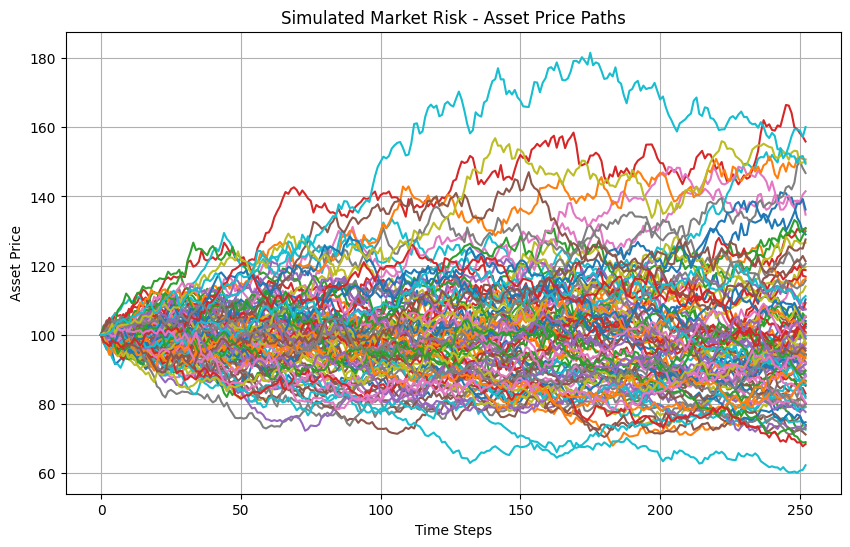

95% VaR: 73.79914900549524
95% Expected Shortfall: 68.07159447750665


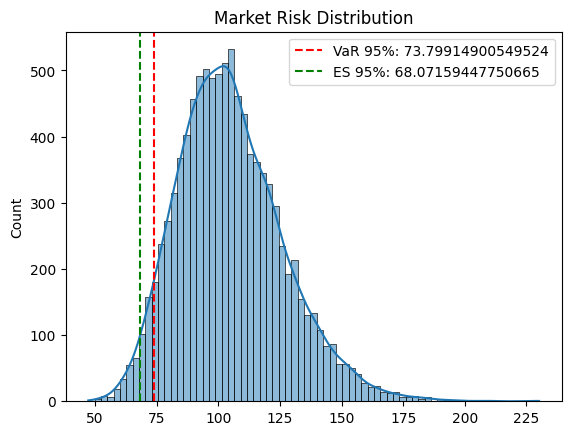

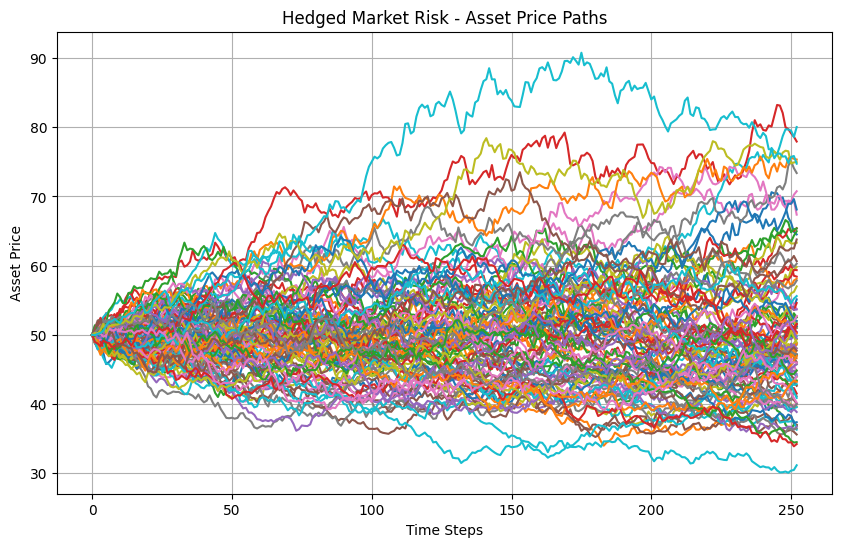

95% VaR (Hedged): 36.89957450274762
95% Expected Shortfall (Hedged): 34.035797238753325


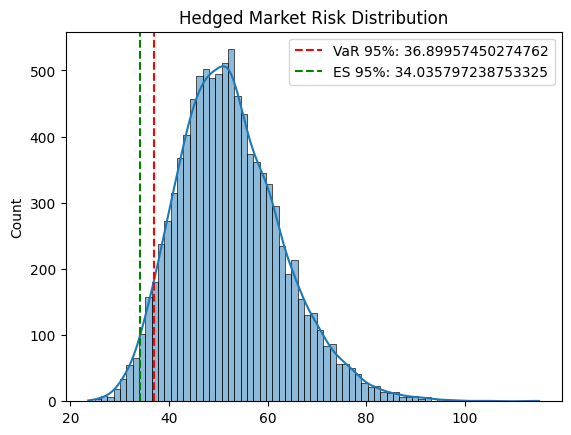

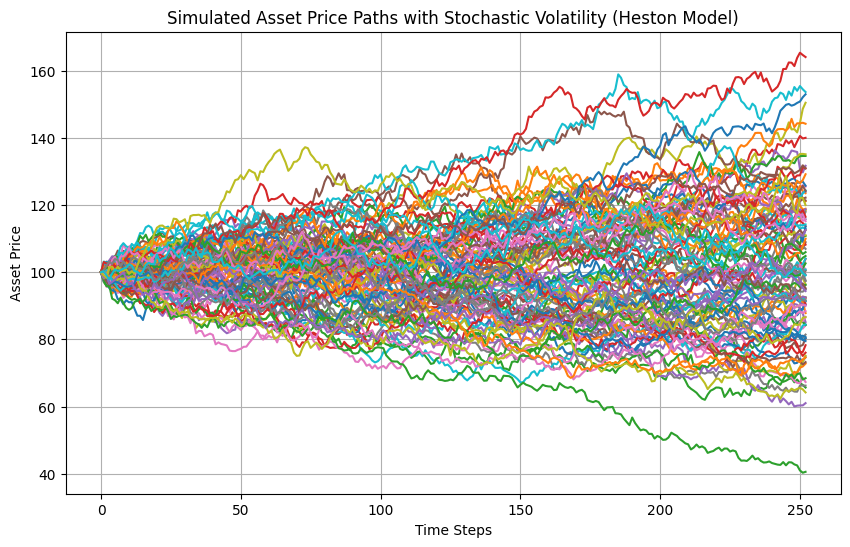

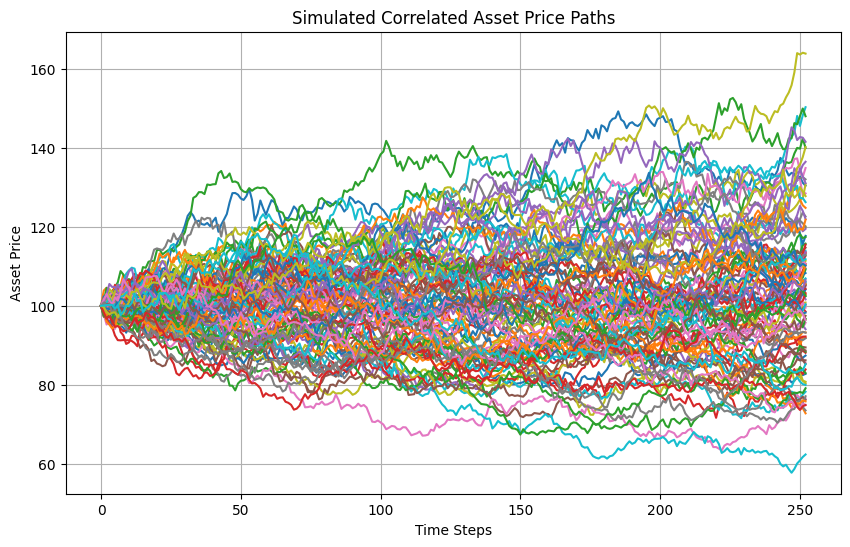

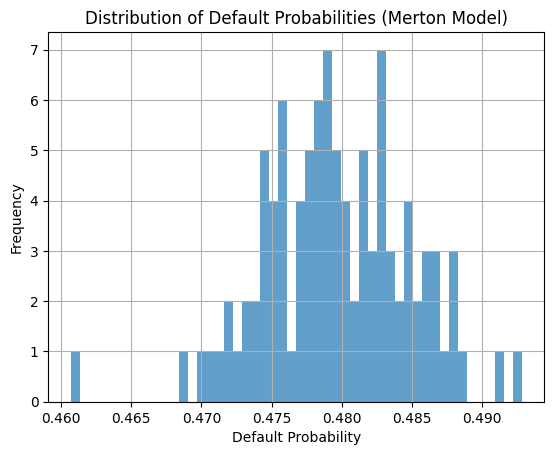

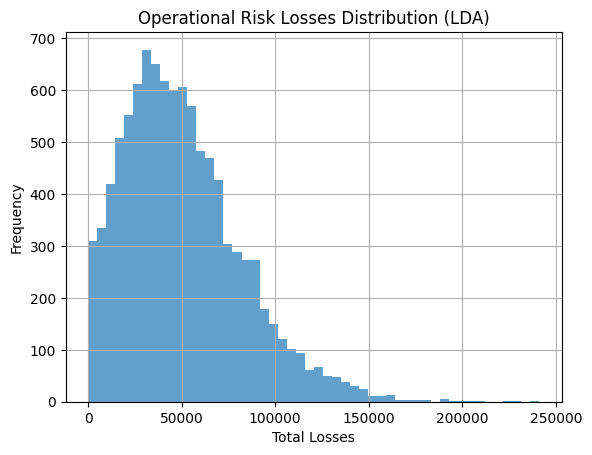

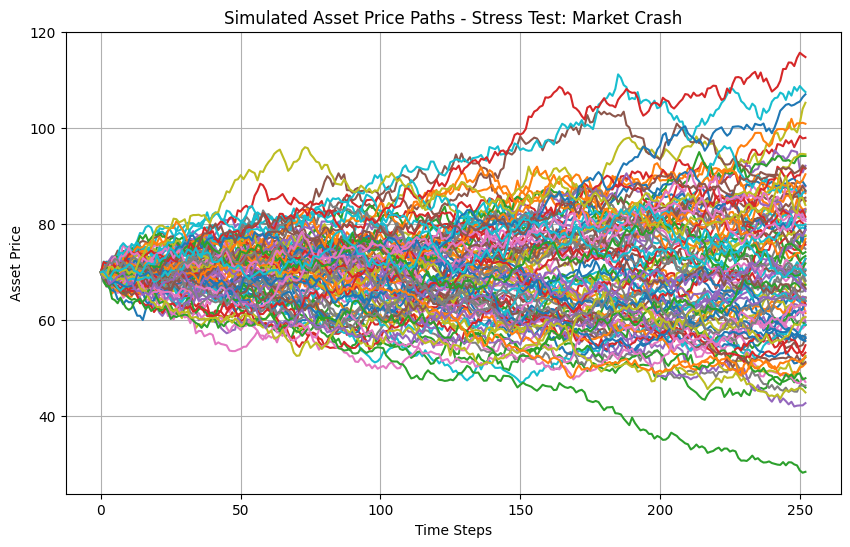

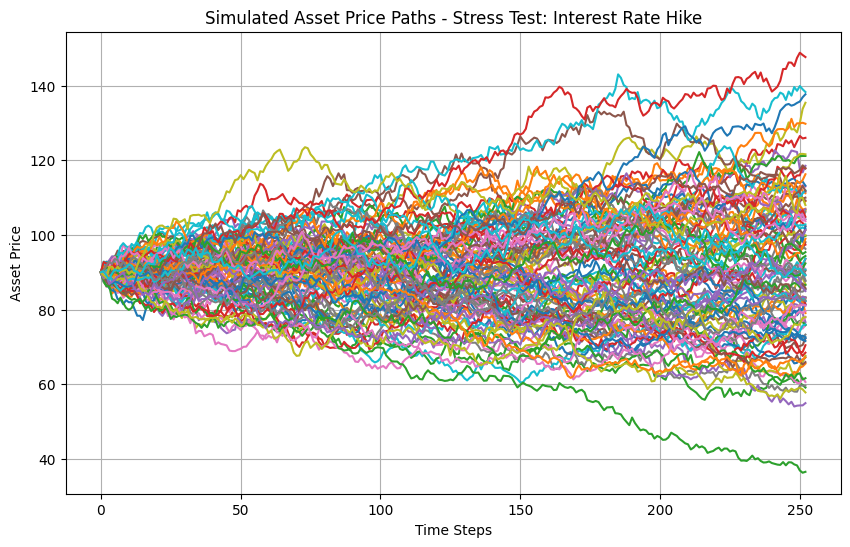

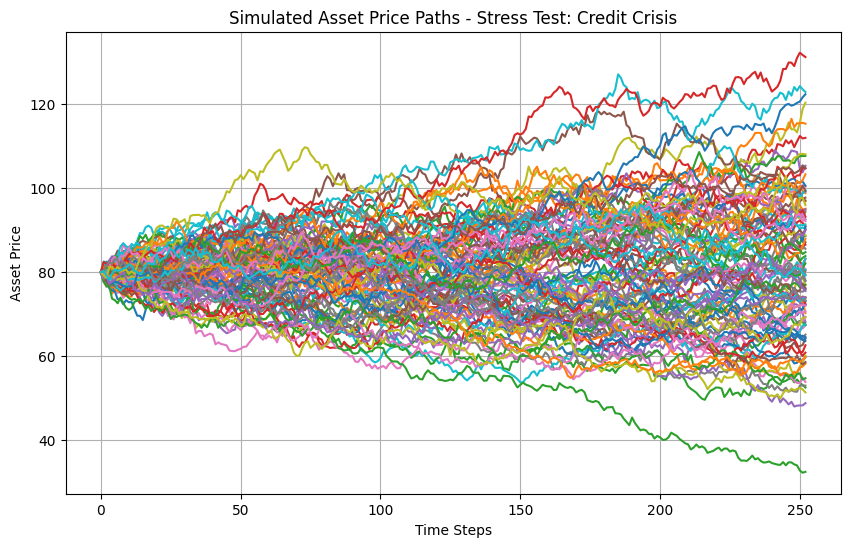

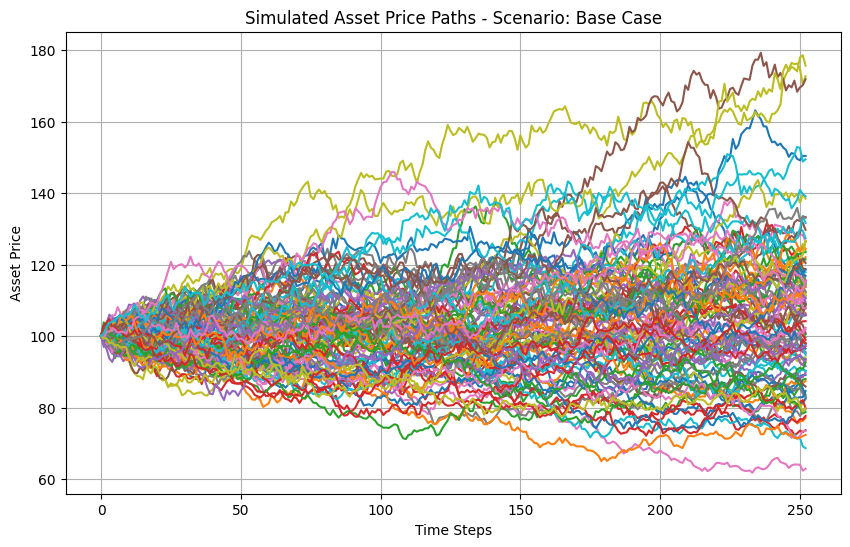

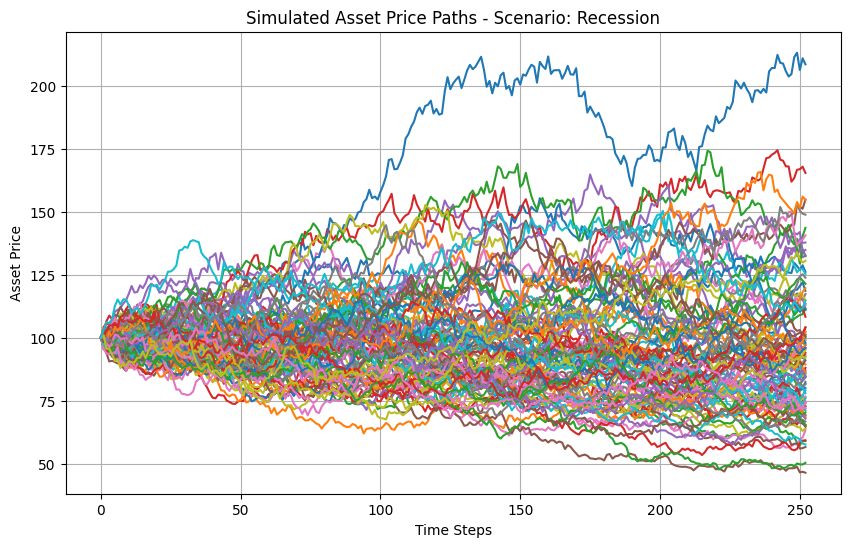

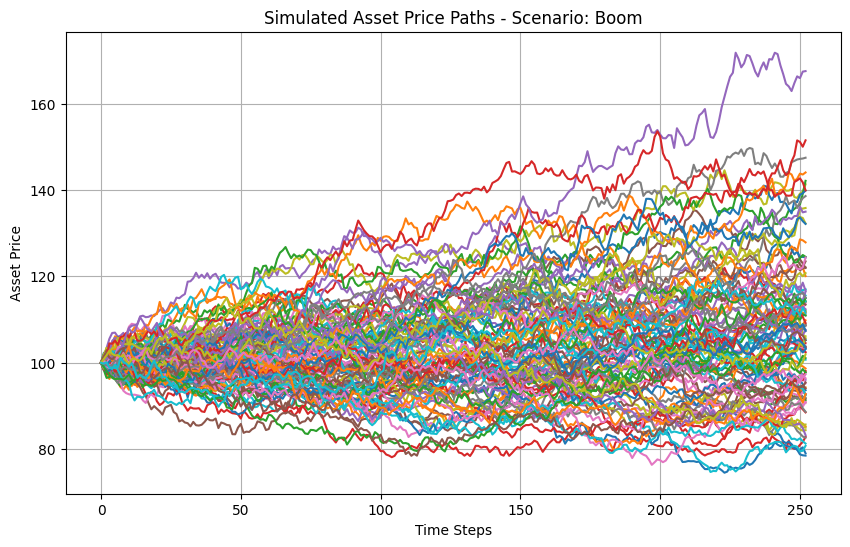

Optimized Portfolio Return: 0.054397848180646954
Optimized Portfolio Volatility: 0.08797096632289383
Sharpe Ratio: 0.2773397769793235
Sortino Ratio: -5.1544835830292035
Maximum Drawdown: -6.99575704171557
Optimized Weights (Risk Parity): [0.58526102 0.41473898]


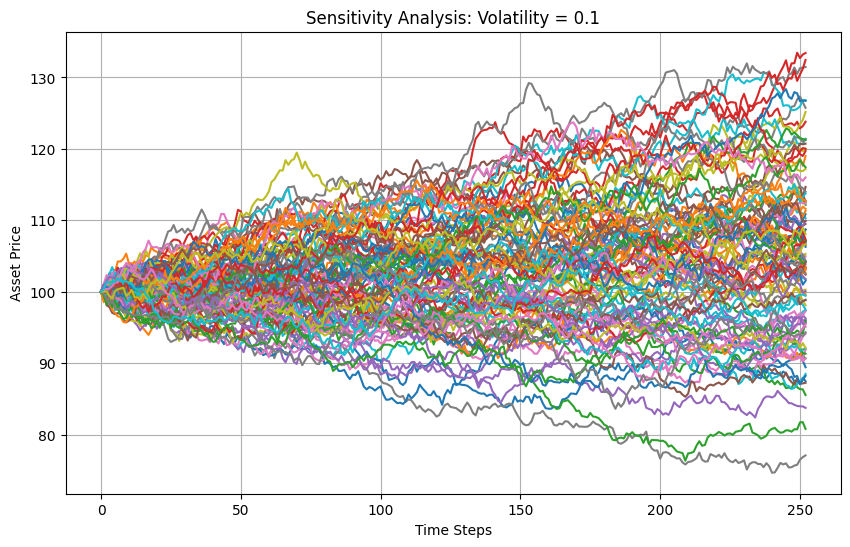

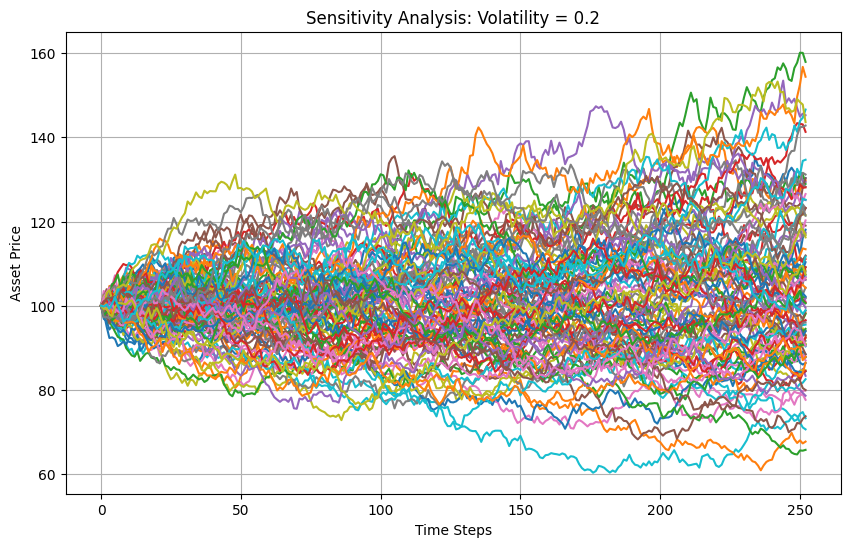

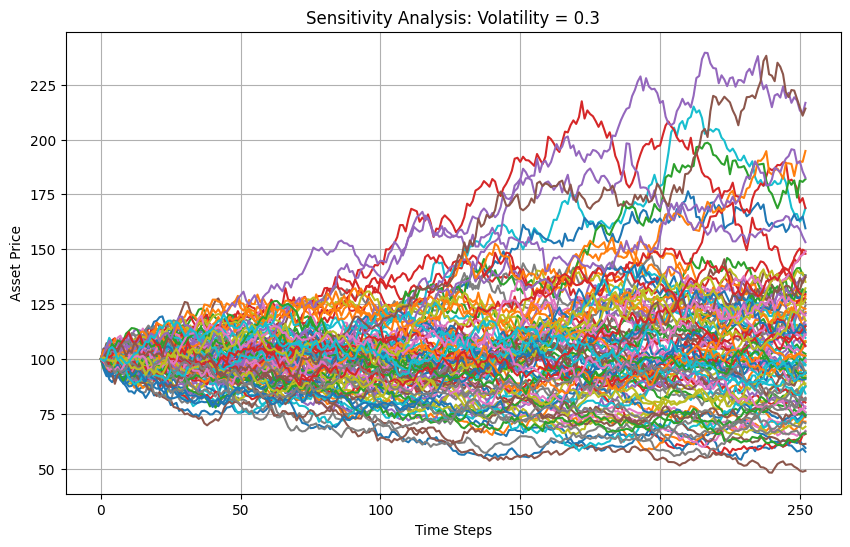

Predictive Model Accuracy: 0.945


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


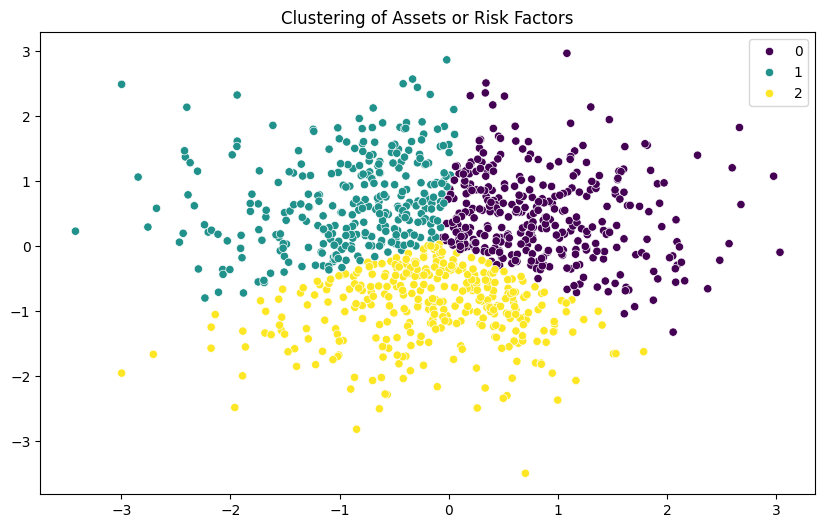

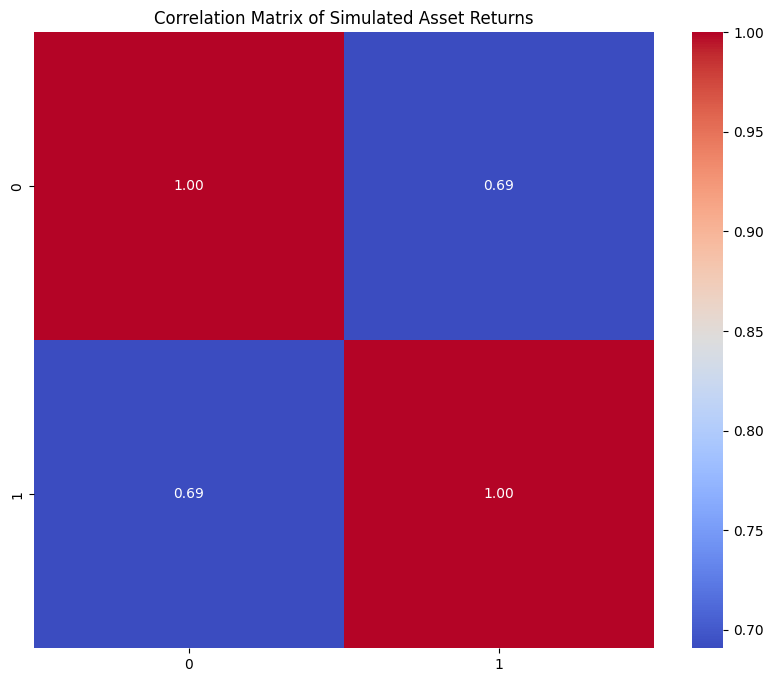

In [26]:
def main():
    # Market Risk (GBM)
    S0 = 100  # initial stock price
    mu = 0.05  # expected return
    sigma = 0.2  # volatility
    T = 1.0  # time horizon (1 year)
    n_simulations = 10000  # number of simulations
    n_steps = 252  # trading days in a year

    # Basic Market Risk Simulation
    market_simulations = simulate_market_risk(S0, mu, sigma, T, n_simulations, n_steps)
    plot_simulations(market_simulations, "Simulated Market Risk - Asset Price Paths")
    # Calculate and Display Risk Metrics
    VaR, ES = calculate_risk_metrics(market_simulations)
    print(f"95% VaR: {VaR}")
    print(f"95% Expected Shortfall: {ES}")
    plot_risk_distribution(market_simulations[-1], VaR, ES, "Market Risk Distribution")

    # Apply a Hedging Strategy
    hedge_ratio = 0.5  # hedge 50% of the position
    hedged_market_simulations = apply_hedge(market_simulations, hedge_ratio)
    plot_simulations(hedged_market_simulations, "Hedged Market Risk - Asset Price Paths")

    # Recalculate and Display Hedged Risk Metrics
    hedged_VaR, hedged_ES = calculate_risk_metrics(hedged_market_simulations)
    print(f"95% VaR (Hedged): {hedged_VaR}")
    print(f"95% Expected Shortfall (Hedged): {hedged_ES}")
    plot_risk_distribution(hedged_market_simulations[-1], hedged_VaR, hedged_ES, "Hedged Market Risk Distribution")

    # Heston Model (Stochastic Volatility)
    V0 = 0.04  # initial variance
    kappa = 2.0  # speed of mean reversion
    theta = 0.04  # long-run variance
    xi = 0.1  # volatility of volatility
    rho = -0.7  # correlation between asset price and variance

    S, V = heston_model(S0, V0, mu, kappa, theta, xi, rho, T, n_simulations, n_steps)
    plot_simulations(S, "Simulated Asset Price Paths with Stochastic Volatility (Heston Model)")

    # Multivariate Market Risk Simulation
    S0_assets = np.array([100, 150])  # initial prices of two assets
    mu_assets = np.array([0.05, 0.04])  # expected returns
    sigma_assets = np.array([0.2, 0.25])  # volatilities
    corr_matrix_assets = np.array([[1.0, 0.7], [0.7, 1.0]])  # correlation matrix

    correlated_simulations = simulate_correlated_assets(S0_assets, mu_assets, sigma_assets, corr_matrix_assets, T, n_simulations, n_steps)
    plot_simulations(correlated_simulations[:, 0, :], "Simulated Correlated Asset Price Paths")

    # Credit Risk (Merton Model)
    n_firms = 100
    r = 0.03  # risk-free rate
    sigma_firm = 0.2  # volatility of firm's assets
    D = 1.0  # debt level

    default_prob = merton_model(n_firms, T, r, sigma_firm, D, n_simulations)
    plt.hist(default_prob, bins=50, alpha=0.7)
    plt.title("Distribution of Default Probabilities (Merton Model)")
    plt.xlabel("Default Probability")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()



    # Operational Risk (LDA)
    event_frequency = 5  # average number of loss events per year
    severity_scale = 10000  # average loss per event

    total_losses = lda_model(event_frequency, severity_scale, n_simulations)
    plt.hist(total_losses, bins=50, alpha=0.7)
    plt.title("Operational Risk Losses Distribution (LDA)")
    plt.xlabel("Total Losses")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Stress Testing
    scenarios = ['Market Crash', 'Interest Rate Hike', 'Credit Crisis']
    stress_factors = [0.7, 0.9, 0.8]  # Example stress factors (e.g., 30% market drop)

    stressed_sims = stress_test(scenarios, S, stress_factors)

    for i, scenario in enumerate(scenarios):
        plot_simulations(stressed_sims[i], f"Simulated Asset Price Paths - Stress Test: {scenario}")

    # Scenario Analysis
    scenario_params = {
        'Base Case': {'mu': 0.05, 'sigma': 0.2},
        'Recession': {'mu': -0.02, 'sigma': 0.3},
        'Boom': {'mu': 0.1, 'sigma': 0.15}
    }

    scenario_results = scenario_analysis(S0, scenario_params, mu, sigma, T, n_simulations, n_steps)

    for scenario, S in scenario_results.items():
        plot_simulations(S, f"Simulated Asset Price Paths - Scenario: {scenario}")

    # Portfolio Optimization
    expected_returns = np.array([0.05, 0.07])
    cov_matrix = np.array([[0.01, 0.002], [0.002, 0.02]])

    portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_optimization(expected_returns, cov_matrix)
    print(f"Optimized Portfolio Return: {portfolio_return}")
    print(f"Optimized Portfolio Volatility: {portfolio_volatility}")
    print(f"Sharpe Ratio: {sharpe_ratio}")

    # Calculate Sortino Ratio and Maximum Drawdown
    daily_returns = np.random.randn(252) / 100  # Example of daily returns over a year
    sortino = sortino_ratio(daily_returns)
    max_dd = max_drawdown(daily_returns)

    print(f"Sortino Ratio: {sortino}")
    print(f"Maximum Drawdown: {max_dd}")

    # Risk Parity Optimization
    optimized_weights = risk_parity_optimization(cov_matrix)
    print(f"Optimized Weights (Risk Parity): {optimized_weights}")

    # Sensitivity Analysis
    volatility_values = [0.1, 0.2, 0.3]
    sensitivity_results = sensitivity_analysis(volatility_values, 'sigma', simulate_market_risk, {
        'S0': 100, 'mu': 0.05, 'sigma': 0.2, 'T': 1.0, 'n_simulations': 10000, 'n_steps': 252
    })

    for volatility, S in sensitivity_results.items():
        plot_simulations(S, f"Sensitivity Analysis: Volatility = {volatility}")

    # Machine Learning (Predictive Modeling)
    X = np.random.randn(1000, 5)  # features (e.g., financial ratios)
    y = np.random.binomial(1, 0.05, 1000)  # binary outcome (default or not)

    accuracy = predictive_modeling(X, y)
    print(f"Predictive Model Accuracy: {accuracy}")

    # Machine Learning (Clustering)
    data = np.random.randn(1000, 2)
    clustering_model(data)

    # Heatmap
    corr_matrix_assets = np.corrcoef(correlated_simulations[-1])
    plot_heatmap(corr_matrix_assets)

if __name__ == "__main__":
    main()
